# **Installation**

In [ ]:
%pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j wikipedia tiktoken yfiles_jupyter_graphs pypdf camelot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


## Importing Libraries

In [ ]:
import re
from langchain.document_loaders import PyPDFLoader
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from langchain.document_loaders import PyPDFLoader
import pandas as pd
import gradio as gr
from openai import ChatCompletion
import openai

## **Encoding Mini LM Transformer**

## Context of unstructured PDF data

In [ ]:
# Define the function
def get_unstructured_context(query):
    """
    Extracts the most relevant sentences from a PDF file based on a user query.

    Parameters:
        pdf_path (str): Path to the PDF file.
        query (str): User query.
        top_n (int): Number of top similar sentences to return. Default is 5.

    Returns:
        list: Top `top_n` sentences most relevant to the query.
    """
    # Load PDF and extract text
    pdf_path = "/content/coa-120486116-01.PDF"
    top_n=5
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Container for sentences
    sentences = []

    # Function to split text into sentences
    def split_into_sentences(text):
        # Basic splitting using common sentence delimiters
        return re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)

    # Extract sentences from each document
    for doc in documents:
        sentences.extend(split_into_sentences(doc.page_content))

    # Remove empty sentences and strip whitespace
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    print("Successfully Extracted")

    # Load SentenceTransformer model
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode the query
    query_embedding = model.encode(query)

    # Encode all sentences
    sentence_embeddings = model.encode(sentences)

    # Compute cosine similarity
    cosine_scores = cosine_similarity([query_embedding], sentence_embeddings)

    # Get top N similar sentences
    top_indices = np.argsort(cosine_scores[0])[-top_n:][::-1]  # Descending order
    unstructured_context = [sentences[idx] for idx in top_indices]

    return unstructured_context

## Context of structured RDF data

In [ ]:
# Define the function
def get_structured_context(query, top_n=10):
    """
    Finds the most relevant rows from a structured CSV dataset based on a query.

    Parameters:
        csv_path (str): Path to the CSV file containing structured data.
        query (str): The user query for which relevant rows are to be found.
        top_n (int): Number of top relevant results to return. Default is 10.

    Returns:
        list: Top `top_n` sentences and their metadata relevant to the query.
    """
    # Load CSV
    csv_path = "/content/coa_docs_sample.csv"
    structured_results = pd.read_csv(csv_path)

    # Initialize SentenceTransformer
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Function to dynamically generate sentences for each row
    def generate_dynamic_sentence(row):
        return ", ".join(
            [f"{col}: {val}" for col, val in row.items() if pd.notnull(val)]
        )

    # Process Rows
    data_points = []
    for _, row in structured_results.iterrows():
        dynamic_sentence = generate_dynamic_sentence(row)
        embedding = model.encode(dynamic_sentence)
        metadata = row.to_dict()
        data_points.append((embedding, metadata, dynamic_sentence))

    # Separate Embeddings, Metadata, and Sentences
    embeddings, metadatas, sentences = zip(*data_points)

    # Encode the query
    query_embedding = model.encode(query)

    # Compute cosine similarity between the query and stored embeddings
    cosine_scores = cosine_similarity([query_embedding], embeddings)

    # Get top N most similar results
    top_indices = np.argsort(cosine_scores[0])[-top_n:][::-1]  # Descending order

    # Collect results
    structured_context = []
    for idx in top_indices:
        structured_context.append({
            "sentence": sentences[idx],
            "metadata": metadatas[idx],
            "score": cosine_scores[0][idx]
        })

    return structured_context



## Feeding GPT-4 model with combined context

In [ ]:
from openai import ChatCompletion
import openai

# Set up OpenAI API key
openai.api_key = "add-your-key"

# Define the function to call the model
def query_chatbot(user_query):
    structured_context = get_structured_context(user_query)

    print("unstructured_context",structured_context)
    unstructured_context = get_unstructured_context(user_query)
    print("structured_context",unstructured_context)

    combined_context = "\n".join([
        "Structured Data:\n" + " ".join(structured_context),
        "Unstructured Data:\n" + " ".join(unstructured_context)
    ])

    print(combined_context)

    try:
        response = ChatCompletion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert assistant combining graph and document data. Summarize Structured Data and answer queries."},
                {"role": "user", "content": f"Answer based on the following data:\n{combined_context}\n Query: {user_query}"}
            ]
        )
        return response['choices'][0]['message']['content']
    except Exception as e:
        return f"An error occurred: {str(e)}"

## User Interface for Chatbot

In [ ]:
# Define Gradio UI
iface = gr.Interface(
    fn=query_chatbot,  # Function to process the query
    inputs="text",  # Single text input
    outputs="text",  # Single text output
    title="Graph & Document Data Chatbot",
    description="Ask a question, and the chatbot will combine structured and unstructured data to provide an accurate response."
)

# Launch the UI
iface.launch()


## Graph Visualization of closest retrieved Data

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

embeddings = np.array(embeddings)
embeddings = embeddings[top_indices]
query_embedding = np.array(query_embedding).reshape((1,-1))

similarity_matrix = cosine_similarity(embeddings)

In [ ]:
# Define a similarity threshold for adding edges
similarity_threshold = 0.6  # Adjust this as needed

# Initialize a new graph with improved aesthetics
G = nx.Graph()

num_nodes = len(embeddings)
# Add nodes
G.add_node("Query")  # Center node
for i in range(1, num_nodes):
    G.add_node(f"Doc{i}")

# Add edges based on threshold
for i in range(1, num_nodes):  # Start with the query (node 0)
    similarity = similarity_matrix[0, i]
    if similarity >= similarity_threshold:  # Add edge if similarity exceeds threshold
        G.add_edge("Query", f"Doc{i}", weight=similarity)

for i in range(1, num_nodes):  # Check between documents
    for j in range(i + 1, num_nodes):
        similarity = similarity_matrix[i, j]
        if similarity >= similarity_threshold:
            G.add_edge(f"Doc{i}", f"Doc{j}", weight=similarity)


In [ ]:
# Define positions manually
pos = nx.spring_layout(G, seed=42)  # Use spring layout as the base
pos["Query"] = [0, 0]  # Place the query in the center

# Adjust document positions based on similarity
for i in range(1, num_nodes):
    similarity = similarity_matrix[-1, i]
    distance = 1 / max(similarity, 0.01)  # Inverse proportionality, avoid div by 0
    angle = (i - 1) * (2 * np.pi / (num_nodes - 1))  # Evenly space documents
    pos[f"Doc{i}"] = [distance * np.cos(angle), distance * np.sin(angle)]

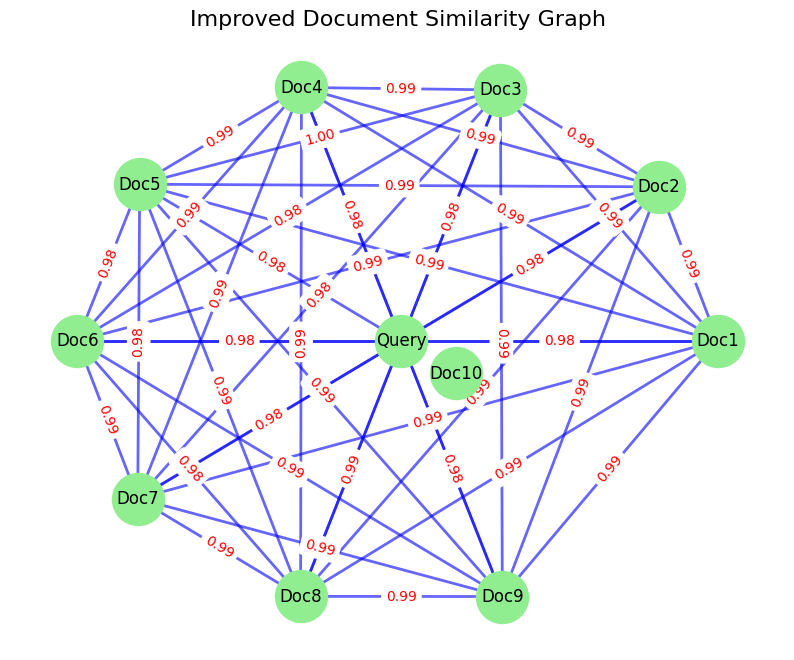

In [ ]:
# Drawing the graph
plt.figure(figsize=(10, 8))

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_size=1400, node_color="lightgreen")
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

# Draw edges with weights
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, width=2, edge_color="blue", alpha=0.6)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in edges},
    font_size=10, font_color="red"
)

# Display the graph
plt.title("Improved Document Similarity Graph", fontsize=16)
plt.axis("off")
plt.show()